In [14]:
from utils import sanitize
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions, AllChem
from rdkit.Chem.Draw import IPythonConsole

from rxnmapper import RXNMapper
rxnmapper = RXNMapper()

Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def make_rxn_sma(rxn_entry):
    reactants = sanitize(list(rxn_entry[0].values()))
    products = sanitize(list(rxn_entry[1].values()))
    sma = ".".join(reactants) + ">>" + ".".join(products)
    return sma

In [21]:
# Take reaction substrates

pred_rxn_sma = 'O=C(O)CCC(CC(=O)O)C(=O)O.\
                NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1\
                >>O=C(O)C=C(CCC(=O)O)C(=O)O.\
                NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

known_rxn_entry = [{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
                    'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
                    {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
                    'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

known_rxn_sma = make_rxn_sma(known_rxn_entry)

# Atom map
m_pred = rxnmapper.get_attention_guided_atom_maps([pred_rxn_sma])[0]['mapped_rxn']
m_known = rxnmapper.get_attention_guided_atom_maps([known_rxn_sma])[0]['mapped_rxn']

# Construct reaction objects
pred_rxn = AllChem.ReactionFromSmarts(m_pred, useSmiles=True)

# Get reaction center

# Compute MCS seeded by reaction center

In [22]:
pred_rxn.Initialize()
pred_rxn.GetReactingAtoms()

((3, 4, 5, 45, 46, 47), (3, 4))

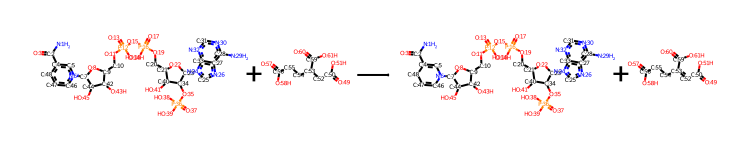

In [23]:
pred_rxn

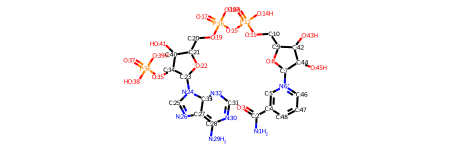

In [28]:
Chem.MolFromSmiles(m_pred.split('.')[0])

In [29]:
m_pred.split('.')[0]

'[NH2:1][C:2](=[O:3])[c:4]1[cH:5][n+:6]([CH:7]2[O:8][CH:9]([CH2:10][O:11][P:12](=[O:13])([OH:14])[O:15][P:16](=[O:17])([OH:18])[O:19][CH2:20][CH:21]3[O:22][CH:23]([n:24]4[cH:25][n:26][c:27]5[c:28]([NH2:29])[n:30][cH:31][n:32][c:33]45)[CH:34]([O:35][P:36](=[O:37])([OH:38])[OH:39])[CH:40]3[OH:41])[CH:42]([OH:43])[CH:44]2[OH:45])[cH:46][cH:47][cH:48]1'

In [3]:
rxn1 = rdChemReactions.ReactionFromRxnBlock('''$RXN

      Mrv2102  111820212128

  2  1
$MOL

  Mrv2102 11182121282D          

 13 13  0  0  0  0            999 V2000
   -7.5723    2.6505    0.0000 C   0  0  0  0  0  0  0  0  0  1  0  0
   -6.8579    2.2380    0.0000 O   0  0  0  0  0  0  0  0  0  2  0  0
   -6.8580    1.4130    0.0000 C   0  0  0  0  0  0  0  0  0  3  0  0
   -6.1435    1.0004    0.0000 O   0  0  0  0  0  0  0  0  0  4  0  0
   -7.5725    1.0005    0.0000 C   0  0  0  0  0  0  0  0  0  5  0  0
   -7.5725    0.1755    0.0000 N   0  0  0  0  0  0  0  0  0  6  0  0
   -8.2869   -0.2369    0.0000 C   0  0  0  0  0  0  0  0  0  7  0  0
   -8.2870   -1.0620    0.0000 C   0  0  0  0  0  0  0  0  0  8  0  0
   -9.0015   -1.4745    0.0000 C   0  0  0  0  0  0  0  0  0  9  0  0
   -9.0015   -2.2995    0.0000 C   0  0  0  0  0  0  0  0  0 10  0  0
   -8.2870   -2.7120    0.0000 C   0  0  0  0  0  0  0  0  0 11  0  0
   -7.5726   -2.2995    0.0000 C   0  0  0  0  0  0  0  0  0 12  0  0
   -7.5726   -1.4745    0.0000 C   0  0  0  0  0  0  0  0  0 13  0  0
  1  2  1  0  0  0  0
  2  3  1  0  0  0  0
  3  4  2  0  0  0  0
  3  5  1  0  0  0  0
  5  6  1  0  0  0  0
  6  7  2  0  0  0  0
  7  8  1  0  0  0  0
  8  9  1  0  0  0  0
  8 13  2  0  0  0  0
  9 10  2  0  0  0  0
 10 11  1  0  0  0  0
 11 12  2  0  0  0  0
 12 13  1  0  0  0  0
M  END
$MOL

  Mrv2102 11182121282D          

 12 11  0  0  0  0            999 V2000
   -3.7934    0.7703    0.0000 C   0  0  0  0  0  0  0  0  0 14  0  0
   -3.0790    1.1828    0.0000 C   0  0  0  0  0  0  0  0  0 15  0  0
   -2.3645    0.7703    0.0000 C   0  0  0  0  0  0  0  0  0 16  0  0
   -3.7934   -0.0547    0.0000 C   0  0  0  0  0  0  0  0  0 17  0  0
   -4.5078   -0.4672    0.0000 O   0  0  0  0  0  0  0  0  0 18  0  0
   -3.0789   -0.4671    0.0000 O   0  0  0  0  0  0  0  0  0 19  0  0
   -1.6500    1.1828    0.0000 O   0  0  0  0  0  0  0  0  0 20  0  0
   -2.3645   -0.0547    0.0000 O   0  0  0  0  0  0  0  0  0 21  0  0
   -3.0788   -1.2922    0.0000 C   0  0  0  0  0  0  0  0  0 22  0  0
   -1.6500   -0.4672    0.0000 C   0  0  0  0  0  0  0  0  0 23  0  0
   -2.3644   -1.7046    0.0000 C   0  0  0  0  0  0  0  0  0 24  0  0
   -1.6500   -1.2922    0.0000 C   0  0  0  0  0  0  0  0  0 25  0  0
  1  2  2  0  0  0  0
  1  4  1  0  0  0  0
  2  3  1  0  0  0  0
  3  7  2  0  0  0  0
  3  8  1  0  0  0  0
  4  5  2  0  0  0  0
  4  6  1  0  0  0  0
  6  9  1  0  0  0  0
  8 10  1  0  0  0  0
  9 11  1  0  0  0  0
 10 12  1  0  0  0  0
M  END
$MOL

  Mrv2102 11182121282D          

 25 26  0  0  0  0            999 V2000
    5.1328    0.9532    0.0000 C   0  0  0  0  0  0  0  0  0  5  0  0
    5.8002    0.4683    0.0000 N   0  0  0  0  0  0  0  0  0  6  0  0
    5.5453   -0.3163    0.0000 C   0  0  0  0  0  0  0  0  0  7  0  0
    4.7203   -0.3163    0.0000 C   0  0  0  0  0  0  0  0  0 14  0  0
    4.4654    0.4683    0.0000 C   0  0  0  0  0  0  0  0  0 15  0  0
    5.1328    1.7782    0.0000 C   0  0  0  0  0  0  0  0  0  3  0  0
    3.6807    0.7232    0.0000 C   0  0  0  0  0  0  0  0  0 16  0  0
    4.2354   -0.9838    0.0000 C   0  0  0  0  0  0  0  0  0 17  0  0
    6.0302   -0.9838    0.0000 C   0  0  0  0  0  0  0  0  0  8  0  0
    6.8507   -0.8975    0.0000 C   0  0  0  0  0  0  0  0  0  9  0  0
    7.3356   -1.5650    0.0000 C   0  0  0  0  0  0  0  0  0 10  0  0
    7.0001   -2.3187    0.0000 C   0  0  0  0  0  0  0  0  0 11  0  0
    6.1796   -2.4049    0.0000 C   0  0  0  0  0  0  0  0  0 12  0  0
    5.6947   -1.7375    0.0000 C   0  0  0  0  0  0  0  0  0 13  0  0
    3.4149   -0.8975    0.0000 O   0  0  0  0  0  0  0  0  0 18  0  0
    4.5709   -1.7375    0.0000 O   0  0  0  0  0  0  0  0  0 19  0  0
    4.0860   -2.4049    0.0000 C   0  0  0  0  0  0  0  0  0 22  0  0
    3.2655   -2.3187    0.0000 C   0  0  0  0  0  0  0  0  0 24  0  0
    3.5092    1.5302    0.0000 O   0  0  0  0  0  0  0  0  0 20  0  0
    3.0676    0.1712    0.0000 O   0  0  0  0  0  0  0  0  0 21  0  0
    2.2830    0.4261    0.0000 C   0  0  0  0  0  0  0  0  0 23  0  0
    1.6699   -0.1259    0.0000 C   0  0  0  0  0  0  0  0  0 25  0  0
    5.8473    2.1907    0.0000 O   0  0  0  0  0  0  0  0  0  4  0  0
    4.4183    2.1907    0.0000 O   0  0  0  0  0  0  0  0  0  2  0  0
    4.4183    3.0157    0.0000 C   0  0  0  0  0  0  0  0  0  1  0  0
  1  2  1  0  0  0  0
  2  3  1  0  0  0  0
  3  4  1  0  0  0  0
  4  5  1  0  0  0  0
  1  5  1  0  0  0  0
  1  6  1  0  0  0  0
  5  7  1  0  0  0  0
  4  8  1  0  0  0  0
  3  9  1  0  0  0  0
 10 11  2  0  0  0  0
 11 12  1  0  0  0  0
 12 13  2  0  0  0  0
 13 14  1  0  0  0  0
  9 10  1  0  0  0  0
  9 14  2  0  0  0  0
  8 15  2  0  0  0  0
  8 16  1  0  0  0  0
 16 17  1  0  0  0  0
 17 18  1  0  0  0  0
  7 19  2  0  0  0  0
  7 20  1  0  0  0  0
 20 21  1  0  0  0  0
 21 22  1  0  0  0  0
  6 23  2  0  0  0  0
  6 24  1  0  0  0  0
 24 25  1  0  0  0  0
M  END
''')